In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras import callbacks as cb
import os, json, math, librosa
import librosa.display as dis
import librosa
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, MaxPooling2D, Input, Activation

import sklearn.model_selection as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00005.wav


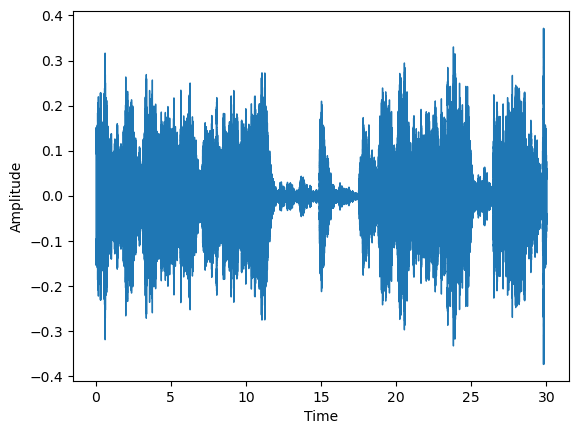

Estimated Tempo: 143.55 BPM


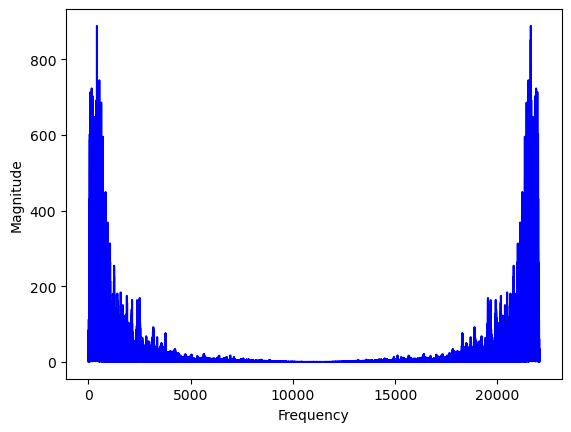

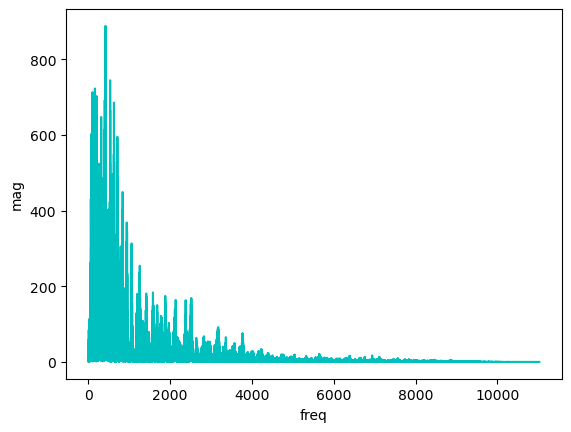

Mean Zero-Crossing Rate: 0.07521004024071926


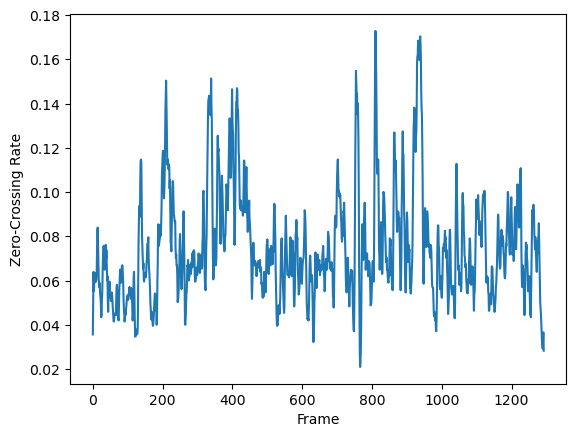

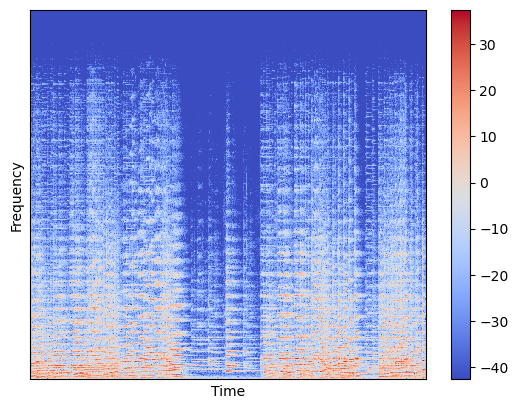

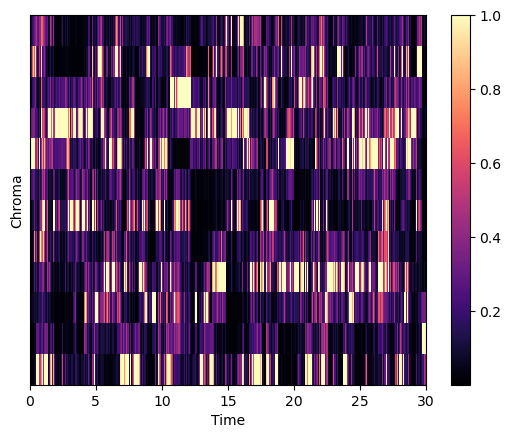

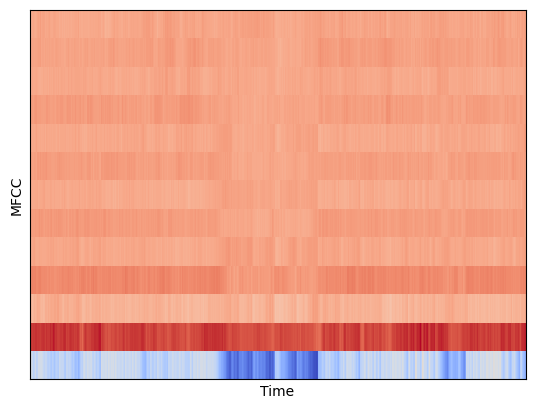

In [2]:
file = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00005.wav"
print(file)


# waveform
signal, sr = librosa.load(file, sr=22050)
dis.waveshow(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

#tempo analysis
tempo, _ = librosa.beat.beat_track(y=signal, sr=sr)
print("Estimated Tempo: {:.2f} BPM".format(tempo))

#fft
fft = np.fft.fft(signal)
magnitude = np.abs(fft)
frequency = np.linspace(0,sr, len(magnitude))
plt.plot(frequency , magnitude, color="b")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

left_freq = frequency[: int(len(frequency) / 2)]
left_mag = magnitude[: int(len(magnitude) / 2)]

plt.plot(left_freq, left_mag, color="c")
plt.xlabel("freq")
plt.ylabel("mag")
plt.show()

#zero crossing rate
n_fft = 2048
hop_length = 512
zcr = librosa.feature.zero_crossing_rate(signal, frame_length=n_fft, hop_length=hop_length)
plt.plot(zcr[0], label='Zero-Crossing Rate')
plt.xlabel("Frame")
plt.ylabel("Zero-Crossing Rate")
print("Mean Zero-Crossing Rate:", np.mean(zcr))
plt.show()

#spectogram
stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectrogram = np.abs(stft)
log_spectrogram = librosa.amplitude_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

#Chroma Feature
chroma = librosa.feature.chroma_stft(y=signal, sr=sr)
librosa.display.specshow(chroma, sr=sr, hop_length=hop_length, x_axis='time')
plt.xlabel("Time")
plt.ylabel("Chroma")
plt.colorbar()
plt.show()

#mfcc
MFCCs = librosa.feature.mfcc(y=signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.show()



In [3]:
import os
import math
import json
import librosa

DATASET_PATH = '../input/gtzan-dataset-music-genre-classification/Data/genres_original/'
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

num_mfcc = 13
n_fft = 2048
hop_length = 512
num_segments = 15

samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

mfcc_list = []
label_list = []

for i, (dirpath, dirnames, filenames) in enumerate(os.walk(DATASET_PATH)):
    if dirpath is not DATASET_PATH:
        semantic_label = dirpath.split("/")[-1]
        print("\nProcessing: {}".format(semantic_label))
        for f in filenames:
            file_path = os.path.join(dirpath, f)
            if file_path != '../input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav':
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                for d in range(num_segments):
                    start = samples_per_segment * d
                    finish = start + samples_per_segment
                    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        mfcc_list.append(mfcc.tolist())
                        label_list.append(i - 1)

with open(JSON_PATH, "w") as fp:
    json.dump({"mfcc": mfcc_list, "labels": label_list}, fp, indent=4)

print("process finished")



Processing: disco

Processing: metal

Processing: reggae

Processing: blues

Processing: rock

Processing: classical

Processing: jazz

Processing: hiphop

Processing: country

Processing: pop
process finished


In [4]:
DATA_PATH = "data_10.json"


def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def prepare_datasets(test_size, validation_size):
    X, y = load_data(DATA_PATH)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

def plot_history(history):
    fig, axs = plt.subplots(2)

    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()
    
    
def predict(model, X, y):
    X = X[np.newaxis, ...]

    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 85, 11, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 43, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 43, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 41, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 2, 32)        0         
 2D)                                                             
                                                        

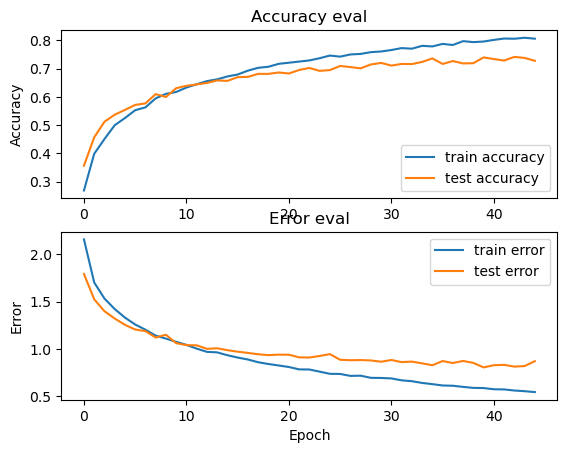

117/117 - 1s - loss: 0.7628 - accuracy: 0.7428 - 645ms/epoch - 6ms/step

Test accuracy: 0.7427884340286255
1/1 [==============================] - 0s 115ms/step
Target: 9, Predicted label: [6]


In [5]:
def cnn_build_model(input_shape):
    cnn_model = keras.Sequential()

    cnn_model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    cnn_model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    cnn_model.add(keras.layers.BatchNormalization())

    cnn_model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    cnn_model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    cnn_model.add(keras.layers.BatchNormalization())

    cnn_model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    cnn_model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    cnn_model.add(keras.layers.BatchNormalization())

    cnn_model.add(keras.layers.Flatten())
    cnn_model.add(keras.layers.Dense(64, activation='relu'))
    cnn_model.add(keras.layers.Dropout(0.2))

    cnn_model.add(keras.layers.Dense(10, activation='softmax'))

    return cnn_model


if __name__ == "__main__":
    
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = cnn_build_model(input_shape)

    optimiser = keras.optimizers.RMSprop(learning_rate=0.0001)
    model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100, callbacks=[early_stopping])
    plot_history(history)

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]

    predict(model, X_to_predict, y_to_predict)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 87, 32)            4512      
                                                                 
 batch_normalization_3 (Batc  (None, 87, 32)           128       
 hNormalization)                                                 
                                                                 
 gru_1 (GRU)                 (None, 87, 32)            6336      
                                                                 
 batch_normalization_4 (Batc  (None, 87, 32)           128       
 hNormalization)                                                 
                                                                 
 gru_2 (GRU)                 (None, 32)                6336      
                                                                 
 batch_normalization_5 (Batc  (None, 32)              

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



281/281 [==============================] - 23s 82ms/step - loss: 0.9114 - accuracy: 0.6831 - val_loss: 1.0662 - val_accuracy: 0.6271
Epoch 83/100
281/281 [==============================] - 24s 84ms/step - loss: 0.8979 - accuracy: 0.6817 - val_loss: 1.0721 - val_accuracy: 0.6231
Epoch 84/100
281/281 [==============================] - 23s 84ms/step - loss: 0.8994 - accuracy: 0.6768 - val_loss: 1.0635 - val_accuracy: 0.6248
Epoch 85/100
281/281 [==============================] - 24s 84ms/step - loss: 0.8930 - accuracy: 0.6817 - val_loss: 1.0636 - val_accuracy: 0.6262
Epoch 86/100
281/281 [==============================] - 24s 84ms/step - loss: 0.8843 - accuracy: 0.6930 - val_loss: 1.0639 - val_accuracy: 0.6253
Epoch 87/100
281/281 [==============================] - 23s 83ms/step - loss: 0.8714 - accuracy: 0.6944 - val_loss: 1.0582 - val_accuracy: 0.6279
Epoch 88/100
281/281 [==============================] - 24s 84ms/step - loss: 0.8668 - accuracy: 0.6926 - val_loss: 1.0632 - val_accuracy

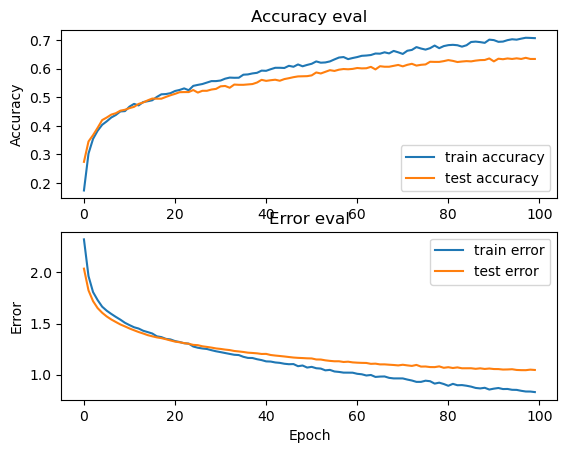

117/117 - 2s - loss: 1.0042 - accuracy: 0.6514 - 2s/epoch - 20ms/step

Test accuracy: 0.651442289352417
1/1 [==============================] - 1s 891ms/step
Target: 4, Predicted label: [4]


In [6]:

# Define the function to build the GRU model
def build_gru_model(input_shape):
    gru_model = keras.Sequential()

    gru_model.add(keras.layers.GRU(32, return_sequences=True, input_shape=input_shape))
    gru_model.add(keras.layers.BatchNormalization())

    gru_model.add(keras.layers.GRU(32, return_sequences=True))
    gru_model.add(keras.layers.BatchNormalization())

    gru_model.add(keras.layers.GRU(32))
    gru_model.add(keras.layers.BatchNormalization())

    gru_model.add(keras.layers.Dense(64, activation='relu'))
    gru_model.add(keras.layers.Dropout(0.2))

    gru_model.add(keras.layers.Dense(10, activation='softmax'))

    return gru_model


if __name__ == "__main__":
    
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)
    input_shape = (X_train.shape[1], X_train.shape[2]) 
    
    model = build_gru_model(input_shape)

    optimiser = keras.optimizers.RMSprop(learning_rate=0.0001)
    model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100, callbacks=[early_stopping])
    plot_history(history)

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)
    
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]

    predict(model, X_to_predict, y_to_predict)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 87, 32)            1280      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 44, 32)           0         
 1D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 44, 32)           128       
 hNormalization)                                                 
                                                                 
 conv1d_4 (Conv1D)           (None, 44, 32)            3104      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 22, 32)           0         
 1D)                                                             
                                                      

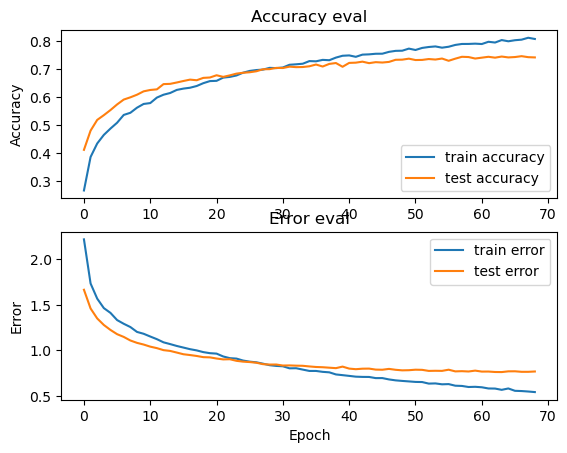

117/117 - 0s - loss: 0.8151 - accuracy: 0.7294 - 364ms/epoch - 3ms/step

Test accuracy: 0.7294337749481201
1/1 [==============================] - 0s 128ms/step
Target: 5, Predicted label: [5]


In [8]:
def tcn_build_model(input_shape):
    tcn_model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv1D(32, kernel_size=3, activation='relu', padding='causal'),
        layers.MaxPooling1D(pool_size=3, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.Conv1D(32, kernel_size=3, activation='relu', padding='causal'),
        layers.MaxPooling1D(pool_size=3, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.Conv1D(32, kernel_size=2, activation='relu', padding='causal'),
        layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    return tcn_model


if __name__ == "__main__":

    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)
    input_shape = (X_train.shape[1], X_train.shape[2]) 
    num_classes = len(np.unique(y_train))

    model = tcn_build_model(input_shape)

    optimiser = keras.optimizers.RMSprop(learning_rate=0.0001)
    model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100, callbacks=[early_stopping])
    plot_history(history)

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)
    
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]

    predict(model, X_to_predict, y_to_predict)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 87, 32)            5888      
                                                                 
 batch_normalization_12 (Bat  (None, 87, 32)           128       
 chNormalization)                                                
                                                                 
 lstm_1 (LSTM)               (None, 87, 32)            8320      
                                                                 
 batch_normalization_13 (Bat  (None, 87, 32)           128       
 chNormalization)                                                
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 batch_normalization_14 (Bat  (None, 32)              

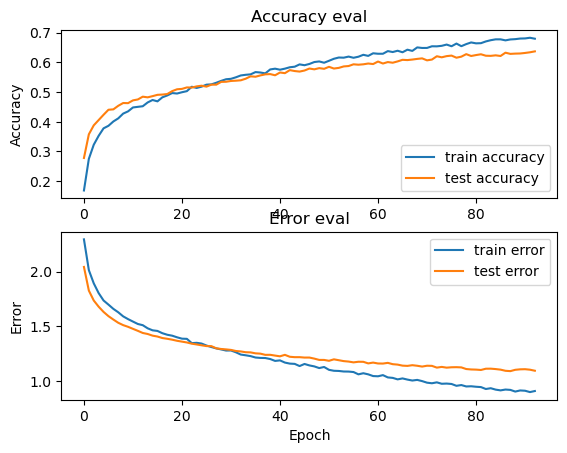

117/117 - 2s - loss: 1.1131 - accuracy: 0.6271 - 2s/epoch - 21ms/step

Test accuracy: 0.627136766910553
1/1 [==============================] - 1s 974ms/step
Target: 5, Predicted label: [5]


In [9]:
def build_lstm_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(32, return_sequences=True),
        layers.BatchNormalization(),
        
        layers.LSTM(32, return_sequences=True),
        layers.BatchNormalization(),
        
        layers.LSTM(32),
        layers.BatchNormalization(),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


if __name__ == "__main__":
  
    input_shape = (X_train.shape[1], X_train.shape[2])  # Adapt based on your input data
    num_classes = len(np.unique(y_train))
    
    model = build_lstm_model(input_shape, num_classes)

    optimiser = keras.optimizers.RMSprop(learning_rate=0.0001)
    model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100, callbacks=[early_stopping])
    plot_history(history)

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    X_to_predict = X_test[100]
    y_to_predict = y_test[100]
    predict(model, X_to_predict, y_to_predict)


Training LSTM... 

Epoch 1/10
281/281 [==============================] - 32s 95ms/step - loss: 2.3315 - accuracy: 0.1678 - val_loss: 2.1036 - val_accuracy: 0.2528
Epoch 2/10
281/281 [==============================] - 25s 90ms/step - loss: 2.0786 - accuracy: 0.2642 - val_loss: 1.9077 - val_accuracy: 0.3445
Epoch 3/10
281/281 [==============================] - 25s 90ms/step - loss: 1.9333 - accuracy: 0.3182 - val_loss: 1.7862 - val_accuracy: 0.3818
Epoch 4/10
281/281 [==============================] - 25s 90ms/step - loss: 1.8406 - accuracy: 0.3472 - val_loss: 1.7080 - val_accuracy: 0.3983
Epoch 5/10
281/281 [==============================] - 25s 89ms/step - loss: 1.7782 - accuracy: 0.3651 - val_loss: 1.6582 - val_accuracy: 0.4210
Epoch 6/10
281/281 [==============================] - 25s 90ms/step - loss: 1.7316 - accuracy: 0.3816 - val_loss: 1.6143 - val_accuracy: 0.4424
Epoch 7/10
281/281 [==============================] - 25s 91ms/step - loss: 1.6872 - accuracy: 0.3974 - val_loss: 1.5

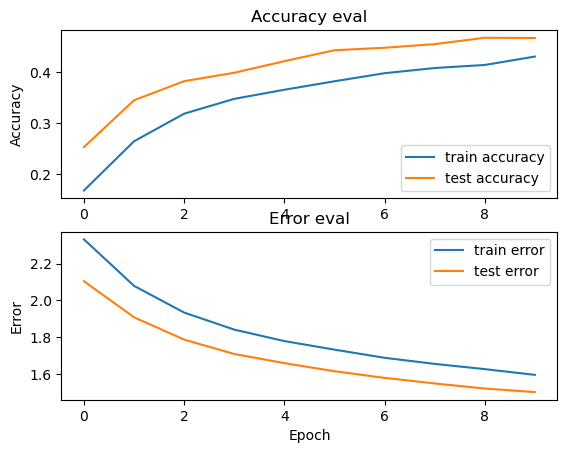

117/117 - 3s - loss: 1.5323 - accuracy: 0.4546 - 3s/epoch - 22ms/step

Test accuracy: 0.4545940160751343
1/1 [==============================] - 1s 984ms/step
Target: 5, Predicted label: [5]
Training CNN... 

Epoch 1/10
281/281 [==============================] - 7s 23ms/step - loss: 2.1679 - accuracy: 0.2700 - val_loss: 1.7010 - val_accuracy: 0.3930
Epoch 2/10
281/281 [==============================] - 6s 22ms/step - loss: 1.7359 - accuracy: 0.3843 - val_loss: 1.4670 - val_accuracy: 0.4757
Epoch 3/10
281/281 [==============================] - 6s 22ms/step - loss: 1.5476 - accuracy: 0.4484 - val_loss: 1.3249 - val_accuracy: 0.5247
Epoch 4/10
281/281 [==============================] - 6s 23ms/step - loss: 1.4336 - accuracy: 0.4894 - val_loss: 1.2395 - val_accuracy: 0.5559
Epoch 5/10
281/281 [==============================] - 6s 22ms/step - loss: 1.3466 - accuracy: 0.5202 - val_loss: 1.1765 - val_accuracy: 0.5821
Epoch 6/10
281/281 [==============================] - 6s 22ms/step - loss: 1.

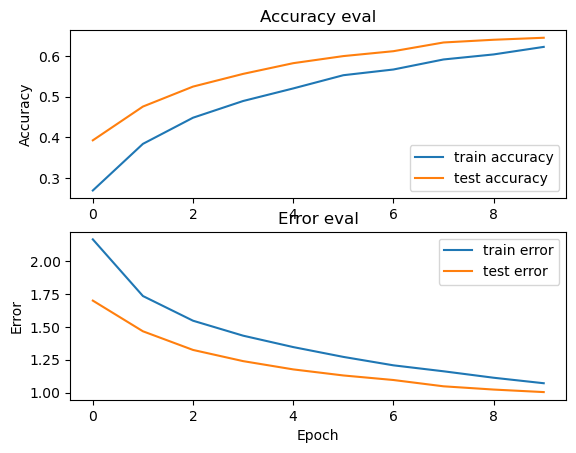

117/117 - 1s - loss: 1.0327 - accuracy: 0.6413 - 726ms/epoch - 6ms/step

Test accuracy: 0.6412927508354187
1/1 [==============================] - 0s 101ms/step
Target: 5, Predicted label: [5]
Training TCN... 

Epoch 1/10
281/281 [==============================] - 4s 11ms/step - loss: 2.1681 - accuracy: 0.2670 - val_loss: 1.7188 - val_accuracy: 0.4041
Epoch 2/10
281/281 [==============================] - 3s 10ms/step - loss: 1.7703 - accuracy: 0.3799 - val_loss: 1.4970 - val_accuracy: 0.4655
Epoch 3/10
281/281 [==============================] - 3s 11ms/step - loss: 1.6047 - accuracy: 0.4287 - val_loss: 1.3734 - val_accuracy: 0.5024
Epoch 4/10
281/281 [==============================] - 3s 10ms/step - loss: 1.4989 - accuracy: 0.4631 - val_loss: 1.3034 - val_accuracy: 0.5269
Epoch 5/10
281/281 [==============================] - 3s 10ms/step - loss: 1.4190 - accuracy: 0.4912 - val_loss: 1.2429 - val_accuracy: 0.5407
Epoch 6/10
281/281 [==============================] - 3s 10ms/step - loss: 

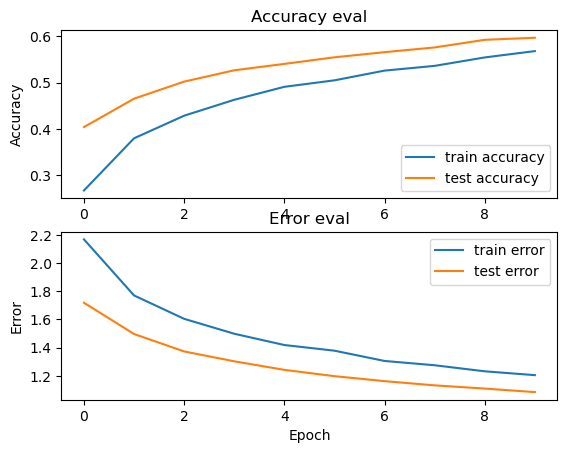

117/117 - 0s - loss: 1.1314 - accuracy: 0.5988 - 392ms/epoch - 3ms/step

Test accuracy: 0.5988247990608215
1/1 [==============================] - 0s 133ms/step
Target: 5, Predicted label: [5]
Training GRU... 

Epoch 1/10
281/281 [==============================] - 34s 102ms/step - loss: 2.1888 - accuracy: 0.2276 - val_loss: 1.9045 - val_accuracy: 0.3502
Epoch 2/10
281/281 [==============================] - 28s 98ms/step - loss: 1.8863 - accuracy: 0.3372 - val_loss: 1.6980 - val_accuracy: 0.4126
Epoch 3/10
281/281 [==============================] - 27s 95ms/step - loss: 1.7704 - accuracy: 0.3727 - val_loss: 1.6051 - val_accuracy: 0.4312
Epoch 4/10
281/281 [==============================] - 27s 98ms/step - loss: 1.6977 - accuracy: 0.3921 - val_loss: 1.5453 - val_accuracy: 0.4401
Epoch 5/10
281/281 [==============================] - 27s 96ms/step - loss: 1.6361 - accuracy: 0.4068 - val_loss: 1.5003 - val_accuracy: 0.4548
Epoch 6/10
281/281 [==============================] - 27s 97ms/step -

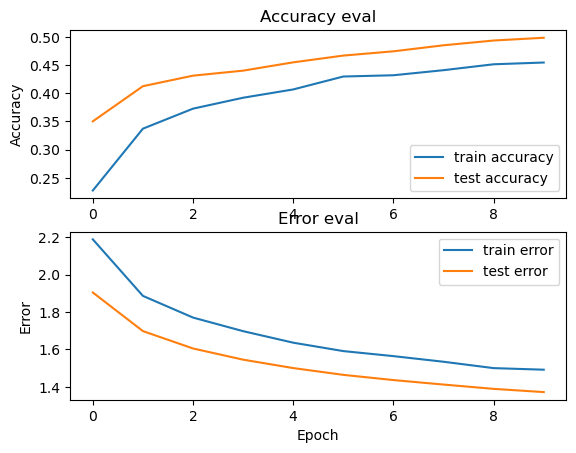

117/117 - 2s - loss: 1.4128 - accuracy: 0.4890 - 2s/epoch - 19ms/step

Test accuracy: 0.48904913663864136
1/1 [==============================] - 1s 937ms/step
Target: 5, Predicted label: [5]
71/71 [==============================] - 1s 20ms/step
Ensemble Accuracy: 0.6639964396973743


In [15]:

lstm_model = build_lstm_model(input_shape, num_classes)
tcn_model = tcn_build_model(input_shape)
gru_model = build_gru_model(input_shape)
input_shape_cnn = (X_train.shape[1], X_train.shape[2], 1)
cnn_model = cnn_build_model(input_shape_cnn)

model_dict = {
    lstm_model: "LSTM",
    tcn_model: "TCN",
    gru_model: "GRU",
    cnn_model: "CNN"
}

# Compile individual models
models = [lstm_model, cnn_model, tcn_model, gru_model]

for model in models:
    optimiser = keras.optimizers.RMSprop(learning_rate=0.0001)
    model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
X_to_predict = X_test[100] 
y_to_predict = y_test[100]

# Train individual models
for model in models:
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    print(f"\n Training {model_dict[model]}... \n")
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=10, callbacks=[early_stopping])
    plot_history(history)  # Plot history for each model
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)
    predict(model, X_to_predict, y_to_predict)

    
# Make predictions using each model
ensemble_predictions = []

for model in models:
    predictions = model.predict(X_validation)  # Use your validation data here
    ensemble_predictions.append(predictions)

# Combine predictions using majority voting
ensemble_predictions = np.argmax(np.sum(ensemble_predictions, axis=0), axis=1)

# Calculate ensemble accuracy
ensemble_accuracy = accuracy_score(y_validation, ensemble_predictions)
print("Ensemble Accuracy:", ensemble_accuracy)
